In [1]:
import torch
from torch import autocast
import numpy as np

from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL
from diffusers import LMSDiscreteScheduler
from diffusers import UNet2DConditionModel
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

from tqdm import tqdm
from PIL import Image

c:\Users\ASUS\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ASUS\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\ASUS\miniconda3\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\ASUS\miniconda3\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pyt

In [2]:
class ImageDiffusionModel:

    def __init__(self, vae, tokenizer, text_encoder, unet,
                 scheduler_LMS, scheduler_DDIM):
        self.vae = vae
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.unet = unet
        self.scheduler_LMS = scheduler_LMS
        self.scheduler_DDIM = scheduler_DDIM
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


    def get_text_embeds(self, text):
        text_input = self.tokenizer(text,
                                    padding='max_length',
                                    max_length=tokenizer.model_max_length,
                                    truncation=True,
                                    return_tensors='pt')
        with torch.no_grad():
            text_embeds = self.text_encoder(text_input.input_ids.to(self.device))[0]

        return text_embeds

    def get_prompt_embeds(self, prompt):
        cond_embeds = self.get_text_embeds(prompt)
        uncond_embeds = self.get_text_embeds([''] * len(prompt))
        prompt_embeds = torch.cat([uncond_embeds, cond_embeds])
        return prompt_embeds

    def get_img_latents(self,
                        text_embeds,
                        height=512, width=512,
                        num_inference_steps=50,
                        guidance_scale=7.5,
                        img_latents=None):

        if img_latents is None:
            img_latents = torch.randn((text_embeds.shape[0] // 2, self.unet.in_channels,\
                                       height // 8, width // 8)).to(self.device)
        self.scheduler_LMS.set_timesteps(num_inference_steps)
        img_latents = img_latents * self.scheduler_LMS.sigmas[0]
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_LMS.timesteps)):
                latent_model_input = torch.cat([img_latents] * 2)
                sigma = self.scheduler_LMS.sigmas[i]
                latent_model_input = latent_model_input / ((sigma ** 2 + 1) ** 0.5)
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeds)['sample']
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
                img_latents = self.scheduler_LMS.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents


    def decode_img_latents(self, img_latents):
        img_latents = img_latents / 0.18215
        with torch.no_grad():
            imgs = self.vae.decode(img_latents)["sample"]
        imgs = imgs.detach().cpu()
        return imgs



    def transform_imgs(self, imgs):
        imgs = (imgs / 2 + 0.5).clamp(0, 1)
        imgs = imgs.permute(0, 2, 3, 1).numpy()
        imgs = (imgs * 255).round().astype('uint8')
        imgs = [Image.fromarray(img) for img in imgs]
        return imgs

    def prompt_to_img(self,
                      prompts,
                      height=512, width=512,
                      num_inference_steps=50,
                      guidance_scale=7.5,
                      img_latents=None):

        if isinstance(prompts, str):
            prompts = [prompts]

        text_embeds = self.get_prompt_embeds(prompts)

        img_latents = self.get_img_latents(text_embeds,
                                      height, width,
                                      num_inference_steps,
                                      guidance_scale,
                                      img_latents)
        imgs = self.decode_img_latents(img_latents)
        imgs = self.transform_imgs(imgs)

        return imgs

    def encode_img_latents(self, imgs):
        if not isinstance(imgs, list):
            imgs = [imgs]

        imgs = np.stack([np.array(img) for img in imgs], axis=0)
        imgs = 2 * ((imgs / 255.0) - 0.5)
        imgs = torch.from_numpy(imgs).float().permute(0, 3, 1, 2)
        img_latents_dist = self.vae.encode(imgs.to(self.device))
        img_latents = img_latents_dist["latent_dist"].mean.clone()
        img_latents *= 0.18215

        return img_latents

    def get_img_latents_similar(self,
                                img_latents,
                                text_embeds,
                                height=512, width=512,
                                num_inference_steps=50,
                                guidance_scale=7.5,
                                start_step=10):
        self.scheduler_DDIM.set_timesteps(num_inference_steps)

        if start_step > 0:
            start_timestep = self.scheduler_DDIM.timesteps[start_step]
            start_timesteps = start_timestep.repeat(img_latents.shape[0]).long()

            noise = torch.randn_like(img_latents)
            img_latents = scheduler_DDIM.add_noise(img_latents, noise, start_timesteps)
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_DDIM.timesteps[start_step:])):
                latent_model_input = torch.cat([img_latents] * 2)
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeds)['sample']
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
                img_latents = self.scheduler_DDIM.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents


    def similar_imgs(self,
                     img,
                     prompt,
                     height=512, width=512,
                     num_inference_steps=50,
                     guidance_scale=7.5,
                     start_step=10):

        img_latents = self.encode_img_latents(img)

        if isinstance(prompt, str):
            prompt = [prompt]

        text_embeds = self.get_prompt_embeds(prompt)

        img_latents = self.get_img_latents_similar(img_latents=img_latents,
                                                   text_embeds=text_embeds,
                                                height=height, width=width,
                                                num_inference_steps=num_inference_steps,
                                                guidance_scale=guidance_scale,
                                                start_step=start_step)

        imgs = self.decode_img_latents(img_latents)
        imgs = self.transform_imgs(imgs)
        torch.cuda.empty_cache()

        return imgs


In [3]:
device = 'cuda'
model_name = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained(model_name,
                                    subfolder='vae').to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(device)
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder='unet').to(device)
scheduler_LMS = LMSDiscreteScheduler(beta_start=0.00085,
                                 beta_end=0.012,
                                 beta_schedule='scaled_linear',
                                 num_train_timesteps=1000)

scheduler_DDIM = DDIMScheduler(beta_start=0.00085,
                               beta_end=0.012,
                               beta_schedule='scaled_linear',
                               num_train_timesteps=1000)

c:\Users\ASUS\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
model = ImageDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

prompts = ["a tulsi plant on the moon"]

imgs = model.prompt_to_img(prompts)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5420\1252103311.py:44: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  img_latents = torch.randn((text_embeds.shape[0] // 2, self.unet.in_channels,\
50it [02:56,  3.53s/it]


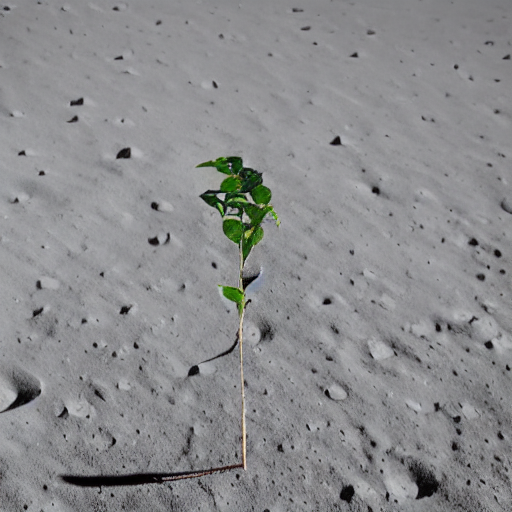

In [7]:
imgs[0]